<a href="https://colab.research.google.com/github/Sahanaka/SER-EE7209_G14/blob/main/speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition**
In this notebook we will experiment SER on a small subset of RAVDESS dataset.

## **Setup**

In [ ]:
!pip install librosa soundfile pyaudio

  ERROR: Failed building wheel for pyaudio
  Running setup.py clean for pyaudio
Failed to build pyaudio
    Running setup.py install for pyaudio ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-39ujgpi2/pyaudio_4b756e901cd144abb78c6a13a5acd201/setup.py'"'"'; __file__='"'"'/tmp/pip-install-39ujgpi2/pyaudio_4b756e901cd144abb78c6a13a5acd201/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-j2_9p7p1/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pyaudio Check the logs for full command output.


## **Imports**

In [ ]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

## **Utilities**

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Preparation**

In [ ]:
audio = "/content/drive/MyDrive/Datasets/RAVDESS_low_sampled/"
actor_folders = os.listdir(audio)
actor_folders

['Actor_22',
 'Actor_15',
 'Actor_21',
 'Actor_17',
 'Actor_23',
 'Actor_16',
 'Actor_18',
 'Actor_19',
 'Actor_24',
 'Actor_20',
 'Actor_13',
 'Actor_06',
 'Actor_07',
 'Actor_05',
 'Actor_14',
 'Actor_08',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_09',
 'Actor_03',
 'Actor_01',
 'Actor_04',
 'Actor_02']

In [ ]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
def extract_labels_from_file_name():
  emotion = []
  actor = []
  file_path = []

  for i in actor_folders:
      filename = os.listdir(audio + i) # Iterate over Actor folders
      for f in filename: # Go through files in Actor folder
          part = f.split('.')[0].split('-')
          emotion.append(int(part[2]))
          actor.append(int(part[6]))
          file_path.append(audio + i + '/' + f)
  return emotion, actor, file_path

In [ ]:
emotion, actor, file_path = extract_labels_from_file_name()

In [ ]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
def create_main_dataframe(emotion, actor, file_path):
  audio_df = pd.DataFrame(emotion)
  audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
  audio_df = pd.concat([audio_df,pd.DataFrame(actor)], axis=1)
  audio_df.columns = ['emotion', 'actor']
  audio_df = pd.concat([audio_df, pd.DataFrame(file_path, columns=['path'])], axis=1)
  return audio_df

In [ ]:
audio_df = create_main_dataframe(emotion, actor, file_path)
audio_df

,emotion,actor,path
0,surprise,22,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
1,fear,22,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
2,disgust,22,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
3,angry,22,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
4,calm,22,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
...,...,...,...
1435,angry,2,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
1436,angry,2,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
1437,fear,2,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...
1438,happy,2,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...


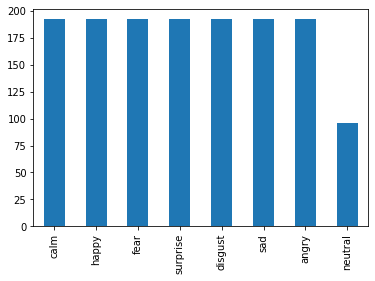

In [ ]:
# LOOK AT DISTRIBUTION OF CLASSES
audio_df.emotion.value_counts().plot(kind='bar')

### Feature Extraction

In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    # Mel-frequency cepstral coefficients (MFCCs)
#     mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#     mfcc=np.mean(mfcc,axis=0)
    
    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()

1440


,mel_spectrogram
0,"[-57.22405, -57.53224, -58.10997, -57.81644, -..."
1,"[-55.876007, -55.876007, -55.876007, -55.85405..."
2,"[-68.03069, -68.12373, -68.33086, -67.613495, ..."
3,"[-68.34898, -68.34898, -68.08023, -67.76666, -..."
4,"[-73.360115, -71.50745, -69.61231, -60.943287,..."


In [ ]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df, pd.DataFrame(df['mel_spectrogram'].values.tolist())], axis=1)
df_combined = df_combined.fillna(0)
df_combined.head()

,emotion,actor,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,surprise,22,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...,-57.224049,-57.532242,-58.109970,-57.816441,-57.670830,-57.024883,-56.654343,-56.473797,-56.094139,-55.017509,-54.578346,-54.584957,-53.499390,-53.015491,-53.360901,-53.305538,-53.863232,-53.916393,-53.050102,-52.322308,-52.533646,-52.610577,-52.613880,-52.262814,-51.887112,-51.989395,-52.616474,-53.234169,-54.308098,-55.123692,-55.942116,-57.229221,-58.330921,-58.387321,-58.074383,-57.691868,-56.938675,...,-58.384514,-58.434830,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.423538,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551
1,fear,22,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...,-55.876007,-55.876007,-55.876007,-55.854057,-55.835625,-55.680691,-48.123680,-43.630074,-46.951904,-51.545033,-51.362625,-50.277412,-48.086613,-46.351212,-45.321323,-44.283360,-44.347305,-44.621136,-44.741310,-45.219296,-45.013870,-43.745850,-43.804951,-42.970524,-41.203564,-41.099224,-41.826881,-41.999050,-41.056370,-41.005302,-41.297215,-41.956421,-42.713017,-44.237392,-46.462742,-48.300823,-50.306145,...,-55.815979,-55.799736,-55.814003,-55.870689,-55.848358,-55.876007,-55.876007,-55.837151,-55.819885,-55.876007,-55.876007,-55.870361,-55.876007,-55.827705,-55.816139,-55.846802,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.834400,-55.812088,-55.831688,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007
2,disgust,22,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...,-68.030693,-68.123734,-68.330856,-67.613495,-67.040283,-66.147865,-65.458206,-65.155128,-63.832821,-60.939133,-58.680706,-51.269695,-45.737694,-45.826275,-49.149414,-50.038391,-52.151443,-54.476757,-55.208832,-55.913307,-56.468937,-57.962791,-58.505859,-59.838699,-61.227863,-62.571880,-63.283501,-64.043205,-65.522980,-67.722313,-69.001869,-68.918335,-68.942451,-69.361748,-68.949150,-68.688980,-69.084312,...,-69.184372,-69.015633,-68.661026,-68.769524,-69.312592,-69.682030,-69.702553,-69.345520,-69.253143,-69.670616,-69.721786,-69.721786,-69.652382,-69.218338,-69.002975,-69.384598,-69.721786,-69.721786,-69.613266,-69.464348,-69.603149,-69.721786,-69.666740,-69.617523,-69.641998,-69.699188,-69.721786,-69.721786,-69.721786,-69.721786,-69.721786,-69.721786,-69.721786,-69.584450,-69.655502,-69.721786,-69.721786,-69.721786,-69.721786,-69.721786
3,angry,22,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...,-68.348984,-68.348984,-68.080231,-67.766663,-67.968567,-68.177917,-68.112732,-68.038773,-68.259628,-68.316216,-68.200287,-68.031898,-67.553864,-65.073563,-57.700897,-56.382172,-59.575867,-60.363838,-61.248745,-61.654331,-61.350845,-61.569584,-60.813084,-60.940498,-61.325672,-62.149845,-63.435345,-64.504356,-65.414474,-66.396599,-67.493034,-67.758751,-67.615723,-66.575203,-66.510414,-62.042076,-60.946110,...,-67.623749,-68.163612,-67.824471,-67.729919,-67.793320,-68.090622,-68.185768,-68.125076,-68.232986,-68.348984,-68.348984,-68.339928,-68.250031,-68.257935,-68.236534,-67.941582,-67.808228,-67.953857,-68.315933,-68.348984,-68.345810,-68.262947,-68.306221,-68.342079,-68.334213,-68.153603,-68.091637,-68.199242,-68.339691,-68.348984,-68.348984,-68.126884,-67.778320,-67.881699,-68.290329,-68.348984,-68.348984,-68.207375,-68.262741,-68.336853
4,calm,22,/content/drive/MyDrive/Datasets/RAVDESS_low_sa...,-73

In [ ]:
df_combined.drop(columns='path', inplace=True)
df_combined.head()

,emotion,actor,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,surprise,22,-57.224049,-57.532242,-58.109970,-57.816441,-57.670830,-57.024883,-56.654343,-56.473797,-56.094139,-55.017509,-54.578346,-54.584957,-53.499390,-53.015491,-53.360901,-53.305538,-53.863232,-53.916393,-53.050102,-52.322308,-52.533646,-52.610577,-52.613880,-52.262814,-51.887112,-51.989395,-52.616474,-53.234169,-54.308098,-55.123692,-55.942116,-57.229221,-58.330921,-58.387321,-58.074383,-57.691868,-56.938675,-57.087418,...,-58.384514,-58.434830,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.423538,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551,-58.435551
1,fear,22,-55.876007,-55.876007,-55.876007,-55.854057,-55.835625,-55.680691,-48.123680,-43.630074,-46.951904,-51.545033,-51.362625,-50.277412,-48.086613,-46.351212,-45.321323,-44.283360,-44.347305,-44.621136,-44.741310,-45.219296,-45.013870,-43.745850,-43.804951,-42.970524,-41.203564,-41.099224,-41.826881,-41.999050,-41.056370,-41.005302,-41.297215,-41.956421,-42.713017,-44.237392,-46.462742,-48.300823,-50.306145,-52.825722,...,-55.815979,-55.799736,-55.814003,-55.870689,-55.848358,-55.876007,-55.876007,-55.837151,-55.819885,-55.876007,-55.876007,-55.870361,-55.876007,-55.827705,-55.816139,-55.846802,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.834400,-55.812088,-55.831688,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007,-55.876007
2,disgust,22,-68.030693,-68.123734,-68.330856,-67.613495,-67.040283,-66.147865,-65.458206,-65.155128,-63.832821,-60.939133,-58.680706,-51.269695,-45.737694,-45.826275,-49.149414,-50.038391,-52.151443,-54.476757,-55.208832,-55.913307,-56.468937,-57.962791,-58.505859,-59.838699,-61.227863,-62.571880,-63.283501,-64.043205,-65.522980,-67.722313,-69.001869,-68.918335,-68.942451,-69.361748,-68.949150,-68.688980,-69.084312,-69.492584,...,-69.184372,-69.015633,-68.661026,-68.769524,-69.312592,-69.682030,-69.702553,-69.345520,-69.253143,-69.670616,-69.721786,-69.721786,-69.652382,-69.218338,-69.002975,-69.384598,-69.721786,-69.721786,-69.613266,-69.464348,-69.603149,-69.721786,-69.666740,-69.617523,-69.641998,-69.699188,-69.721786,-69.721786,-69.721786,-69.721786,-69.721786,-69.721786,-69.721786,-69.584450,-69.655502,-69.721786,-69.721786,-69.721786,-69.721786,-69.721786
3,angry,22,-68.348984,-68.348984,-68.080231,-67.766663,-67.968567,-68.177917,-68.112732,-68.038773,-68.259628,-68.316216,-68.200287,-68.031898,-67.553864,-65.073563,-57.700897,-56.382172,-59.575867,-60.363838,-61.248745,-61.654331,-61.350845,-61.569584,-60.813084,-60.940498,-61.325672,-62.149845,-63.435345,-64.504356,-65.414474,-66.396599,-67.493034,-67.758751,-67.615723,-66.575203,-66.510414,-62.042076,-60.946110,-64.308670,...,-67.623749,-68.163612,-67.824471,-67.729919,-67.793320,-68.090622,-68.185768,-68.125076,-68.232986,-68.348984,-68.348984,-68.339928,-68.250031,-68.257935,-68.236534,-67.941582,-67.808228,-67.953857,-68.315933,-68.348984,-68.345810,-68.262947,-68.306221,-68.342079,-68.334213,-68.153603,-68.091637,-68.199242,-68.339691,-68.348984,-68.348984,-68.126884,-67.778320,-67.881699,-68.290329,-68.348984,-68.348984,-68.207375,-68.262741,-68.336853
4,calm,22,-73.360115,-71.507446,-69.612312,-60.943287,-51.580940,-50.833038,-56.743671,-62.886532,-63.352493,-63.220711,-62.516624,-62.894058,-60.930073,-59.657242,-60.871273,-60.567726,-60.722641,-60.556808,-61.307911,-6

### Data Preparation for modeling

In [ ]:
# TRAIN, VALIDATION & TEST SPLITS
def create_data_splits(data_frame, split_size):
  # TRAIN TEST SPLIT DATA
  train_set, test_set = train_test_split(data_frame, test_size=split_size, random_state=0,
                               stratify=data_frame[['emotion', 'actor']])
  # TRAIN VALIDATION SPLIT
  train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=0)

  return train_set, validation_set, test_set

In [ ]:
train, validation, test = create_data_splits(df_combined, split_size=0.2)

In [ ]:
print(train.shape)
print(validation.shape)
print(test.shape)

(921, 261)
(231, 261)
(288, 261)


In [ ]:
# SEPERATE FEATURES AND LABELS
def create_features_labels_arrays(train, validation, test):
  # Training set
  X_train = train.iloc[:, 3:]
  y_train = train.iloc[:,:1]

  # Testing set
  X_test = test.iloc[:,3:]
  y_test = test.iloc[:,:1]

  # Validation set
  X_validation = validation.iloc[:,3:]
  y_validation = validation.iloc[:,:1]

  return X_train, y_train, X_test, y_test, X_validation, y_validation

In [ ]:
X_train, y_train, X_test, y_test, X_validation, y_validation = create_features_labels_arrays(train, validation, test)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(921, 258)
(288, 258)
(231, 258)


### Data Preprocessing

In [ ]:
# NORMALIZE DATA
def normalize(X_train, X_test, X_validation):
  mean = np.mean(X_train, axis=0)
  std = np.std(X_train, axis=0)
  X_train = (X_train - mean) / std
  X_test = (X_test - mean) / std
  X_validation = (X_validation - mean) /std
  return X_train, X_validation, X_test

In [ ]:
X_train, X_validation, X_test = normalize(X_train, X_test, X_validation)

In [ ]:
X_train

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
411,2.222366,2.105752,2.037208,1.982639,1.855904,1.810389,1.749319,1.695402,1.609441,1.535754,1.504699,1.502669,1.501547,1.455559,1.421526,1.413895,1.385150,1.332269,1.327441,1.337314,1.331719,1.310498,1.294169,1.276572,1.253362,1.219331,1.206153,1.216832,1.222427,1.232066,1.244307,1.265489,1.280328,1.299370,1.332187,1.354466,1.392720,1.434093,1.453951,1.464196,...,0.739820,0.760907,0.786584,0.719073,0.718517,0.726702,0.735216,0.756068,0.871862,1.059553,1.096086,0.764391,0.683007,0.665785,0.625141,0.679854,0.627683,0.421571,0.424317,0.425874,0.340171,0.344366,0.348766,0.255036,0.257617,0.258446,0.186014,0.189159,0.194452,0.124239,0.128260,0.131588,0.063955,0.067021,-0.014850,-0.012599,-0.010586,-0.112477,-0.112833,-0.113843
717,2.318944,2.296653,2.302582,2.282549,2.229471,2.278829,2.282335,2.254626,2.200336,2.212354,2.294234,2.340735,2.328073,2.344598,2.330121,2.391321,2.435212,2.358390,2.293781,2.189560,2.136354,2.078615,1.989193,1.930269,1.939537,1.862946,1.803773,1.838841,1.851708,1.794216,1.783840,1.794636,1.761574,1.666291,1.651859,1.687304,1.728244,1.856106,2.078547,2.391425,...,1.628744,1.607702,1.568549,1.467595,1.437051,1.413656,1.395848,1.379772,1.346973,1.108388,1.073093,0.907406,0.880198,0.849511,0.723381,0.730408,0.741431,0.584828,0.596009,0.608113,0.517821,0.539432,0.569487,0.475485,0.509184,0.521271,0.436965,0.444552,0.451381,0.375053,0.375591,0.361403,0.283851,0.285549,0.190470,0.192326,0.185057,0.060992,0.072927,0.058524
1397,-0.372368,-0.374460,-0.379062,-0.382380,-0.387140,-0.387534,-0.389425,-0.401298,-0.409017,-0.405832,-0.376114,-0.020596,0.295790,0.318992,0.493119,0.265474,-0.023771,-0.370251,-0.464646,-0.474531,-0.478624,-0.482376,-0.481979,-0.475127,-0.473076,-0.467664,-0.458828,-0.448748,-0.441766,-0.412242,-0.396546,-0.431373,-0.440943,-0.452906,-0.470493,-0.503215,-0.522288,-0.549650,-0.596615,-0.596101,...,-0.532694,-0.529581,-0.537753,-0.543166,-0.557973,-0.557605,-0.562427,-0.543567,-0.530036,-0.538745,-0.514623,-0.518095,-0.500679,-0.499076,-0.507603,-0.463149,-0.463735,-0.522134,-0.513956,-0.496900,-0.521183,-0.540065,-0.541237,-0.572548,-0.570808,-0.565581,-0.585272,-0.578199,-0.599506,-0.617446,-0.601560,-0.602449,-0.656452,-0.652166,-0.704400,-0.698119,-0.698397,-0.772326,-0.775875,-0.781778
1018,-0.323079,-0.333235,-0.345421,-0.366576,-0.382409,-0.285430,-0.188845,-0.290448,-0.312513,-0.318612,-0.339572,-0.356054,-0.367896,-0.408080,-0.412032,-0.358520,-0.366187,-0.389175,-0.387054,-0.394909,-0.386154,-0.403224,-0.417373,-0.404951,-0.410327,-0.428440,-0.300686,-0.196194,-0.244103,-0.297571,-0.319025,-0.267388,-0.267913,-0.267247,0.153430,0.788187,0.698909,0.314816,0.029302,0.033778,...,-0.313914,-0.261916,-0.221870,-0.294470,-0.232904,-0.162850,-0.252379,-0.255463,-0.185270,-0.265264,-0.278209,-0.312034,-0.368731,-0.398189,-0.360643,-0.329168,-0.353285,-0.414890,-0.441394,-0.438931,-0.471075,-0.467116,-0.478610,-0.457072,-0.391177,-0.466877,-0.521897,-0.524783,-0.520954,-0.550534,-0.555644,-0.560028,-0.598603,-0.611902,-0.680914,-0.670964,-0.693525,-0.781794,-0.782569,-0.781175
1231,0.545498,0.552768,0.502783,0.520323,0.551248,0.566709,0.567189,0.604625,0.638088,0.650355,0.590503,0.624797,0.700002,0.626105,0.593907,0.584107,0.615863,0.672770,0.694768,0.693318,0.737367,0.772394,0.728567,0.694640,0.706507,0.696564,0.569221,0.467844,0.366340,0.315127,0.224807,0.162571,0.159136,0.280145,0.907591,0.920809,0.331541,0.197781,0.166826,0.134171,...,1.318768,1.392864,1.415146,1.241869,1.177634,1.080011,0.872394,0.658855,0.549426,0.322583,0.388757,0.460148,0.590850,0.737732,0.713762,0.697778,0.596733,0.304710,0.112398,0.013572,-0.056679,-0.132732,-0.135178,-0.137110,-0.145013,-0.126971,-0.133848,-0.121294,-0.078449,-0.111332,-0.13

In [ ]:
X_test

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
400,-0.189001,-0.191658,-0.197439,-0.202004,-0.208120,-0.210204,-0.213413,-0.226121,-0.235282,-0.244597,-0.250474,-0.255422,-0.263036,-0.267188,-0.271289,-0.281032,-0.291803,-0.298206,-0.304094,-0.308497,-0.312940,-0.317694,-0.318745,-0.313749,-0.312804,-0.308700,-0.300327,-0.290190,-0.283341,-0.281163,-0.279815,-0.276425,-0.277084,-0.286791,-0.300331,-0.326505,-0.352471,-0.372005,-0.409624,-0.450642,...,-0.481596,-0.470619,-0.462418,-0.463298,-0.455171,-0.446698,-0.441161,-0.436128,-0.428683,-0.441987,-0.437328,-0.445955,-0.437987,-0.430912,-0.447546,-0.440041,-0.436399,-0.470139,-0.463450,-0.457809,-0.487759,-0.483463,-0.479544,-0.514548,-0.512967,-0.512983,-0.549133,-0.546689,-0.541503,-0.577079,-0.572357,-0.569098,1.884106,1.887535,1.728652,1.729758,1.731223,1.548339,1.547529,1.545086
1373,-0.898488,-0.898962,-0.900178,-0.899917,-0.900788,-0.896335,-0.894445,-0.903921,-0.907503,-0.915313,-0.920900,-0.925402,-0.931609,-0.930850,-0.930339,-0.936940,-0.944849,-0.945801,-0.946885,-0.950920,-0.954009,-0.954887,-0.950334,-0.938158,-0.932932,-0.923768,-0.913602,-0.903685,-0.896325,-0.830288,-0.657546,-0.678968,-0.882756,-0.929528,-0.958726,-1.010235,-1.062922,-1.107251,-1.168269,-1.157726,...,-0.525112,-0.598584,-0.560581,-0.484469,-0.491518,-0.562129,-0.688765,-0.843572,-0.761375,-0.670602,-0.624808,-0.636790,-0.648581,-0.685310,-0.637083,-0.605379,-0.634129,-0.720590,-0.520885,-0.308501,-0.458217,-0.667329,-0.754580,-0.804063,-0.787956,-0.761056,-0.690201,-0.576608,-0.515514,-0.569756,-0.644571,-0.614236,-0.628684,-0.615066,-0.704628,-0.784258,-0.800927,-0.820413,-0.821124,-0.882121
1127,1.245247,1.239534,1.225002,1.208845,1.192127,1.176828,1.163311,1.145546,1.127308,1.113295,1.108106,1.113038,1.101302,1.082822,1.061273,1.044903,1.031613,1.020452,1.002293,0.992071,0.983047,0.970409,0.958028,0.948511,0.940803,0.934678,0.939424,0.950007,0.955824,0.964142,0.974454,0.992486,1.004581,1.012518,1.030631,1.064507,1.095709,1.120445,1.128478,1.137976,...,2.676938,2.575201,2.482200,2.276940,2.269251,2.236783,2.135749,2.056425,1.931084,1.635320,1.692730,1.622714,1.443763,1.239307,0.950576,0.860102,0.766730,0.562012,0.527475,0.481954,0.368677,0.315827,0.282686,0.167974,0.170404,0.163364,0.098413,0.098304,0.093450,0.028319,0.037144,0.039926,-0.031078,-0.034020,-0.112099,-0.109929,-0.102450,-0.197902,-0.202066,-0.204771
1019,0.876078,0.922102,0.856568,1.328281,1.844450,1.597471,0.921893,0.703746,0.674302,0.758613,0.716126,0.551079,0.571656,0.615637,0.653737,0.600570,0.712012,0.977086,0.916761,0.829094,0.891843,1.302346,1.497337,1.329175,1.195012,0.980404,0.772659,0.649709,0.456616,0.293103,0.182242,0.130230,0.118412,0.137511,0.389539,0.872571,0.896359,0.424085,0.204580,0.187213,...,0.273016,0.317394,0.311135,0.233385,0.274671,0.332025,0.351615,0.360342,0.321575,0.264863,0.255892,0.268099,0.275348,0.307944,0.279787,0.335868,0.361678,0.232748,0.252490,0.301346,0.228754,0.177970,0.141518,0.101383,0.151984,0.145346,0.034644,0.028392,0.054454,-0.005191,0.002193,-0.005814,-0.026712,-0.020739,-0.100688,-0.116407,-0.123409,-0.227774,-0.216529,-0.216366
792,-0.700264,-0.663265,-0.656711,-0.671549,-0.692557,-0.697349,-0.697572,-0.715739,-0.705348,-0.715196,-0.335240,-0.245272,-0.537449,-0.627136,-0.661924,-0.692251,-0.706133,-0.725802,-0.727913,-0.718376,-0.705736,-0.736275,-0.758462,-0.751019,-0.711097,-0.703610,-0.716471,-0.698999,-0.675643,-0.684011,-0.698939,-0.681495,-0.690842,-0.747267,-0.787380,-0.773617,-0.720199,-0.744078,-0.832469,-0.794526,...,-0.834496,-0.809076,-0.806780,-0.794985,-0.781358,-0.772438,-0.761747,-0.762755,-0.784213,3.562308,3.597142,3.416764,3.432451,3.453789,3.155416,3.173484,3.193644,2.790072,2.807177,2.822126,2.584983,2.589392,2.595098,2.342108,2.3474

In [ ]:
X_validation

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
1300,-0.479962,-0.481723,-0.485632,-0.488218,-0.492183,-0.491586,-0.492704,-0.504087,-0.510960,-0.519658,-0.525416,-0.530181,-0.537217,-0.539356,-0.541565,-0.550020,-0.559617,-0.563785,-0.567702,-0.571954,-0.575842,-0.579006,-0.577759,-0.569819,-0.567118,-0.560939,-0.551831,-0.541784,-0.534726,-0.533794,-0.534264,-0.533844,-0.537090,-0.550377,-0.570339,-0.606902,-0.637495,-0.673529,-0.720744,-0.754298,...,-0.685488,-0.675798,-0.668506,-0.658509,-0.650712,-0.642505,-0.634802,-0.631440,-0.624415,-0.622084,-0.618782,-0.619684,-0.612063,-0.605629,-0.609592,-0.602562,-0.599664,-0.616770,-0.610550,-0.605327,-0.625958,-0.621667,-0.617828,-0.643029,-0.641615,-0.641771,-0.671865,-0.669537,-0.664369,-0.694163,-0.689324,-0.686076,1.884106,1.887535,1.728652,1.729758,1.731223,1.548339,1.547529,1.545086
485,-0.807771,-0.808523,-0.752115,-0.689503,-0.768492,-0.490641,0.004104,-0.057394,-0.308023,-0.411320,-0.655269,-0.676408,-0.775425,-0.826136,-0.826144,-0.853073,-0.861348,-0.862998,-0.864696,-0.868777,-0.872040,-0.873413,-0.869576,-0.858319,-0.853640,-0.845123,-0.835187,-0.825241,-0.817947,-0.818419,-0.820937,-0.823864,-0.830025,-0.847345,-0.874541,-0.922811,-0.972081,-1.007979,-0.957596,-0.820351,...,-0.859929,-0.847316,-0.846760,-0.849406,-0.824325,-0.775163,-0.799613,-0.847305,-0.829506,-0.776554,-0.775575,-0.772715,-0.752811,-0.745407,-0.769652,-0.775563,-0.764878,-0.778713,-0.773438,-0.740014,-0.767258,-0.777374,-0.765096,-0.787207,-0.786555,-0.779700,-0.800152,-0.797520,-0.788736,-0.812957,-0.815643,-0.817868,-0.844505,-0.836166,-0.875300,-0.875985,-0.877691,-0.938265,-0.939748,-0.927152
1123,-0.259405,-0.261846,-0.255736,-0.266860,-0.276374,-0.278291,-0.280994,-0.293381,-0.301989,-0.311154,-0.317002,-0.321906,-0.329380,-0.333045,-0.336688,-0.346120,-0.356607,-0.362469,-0.366889,-0.349261,-0.351605,-0.352034,-0.354593,-0.346655,-0.347651,-0.345841,-0.351169,-0.351069,-0.335166,-0.321060,-0.337496,-0.337043,-0.339998,-0.350024,-0.358716,-0.390284,-0.411228,-0.428523,-0.472884,-0.505964,...,0.199853,0.216288,0.167812,0.053130,-0.038766,-0.037993,-0.042046,-0.057232,-0.139343,-0.221264,-0.212701,-0.280161,-0.307562,-0.328842,-0.340551,-0.343333,-0.387113,-0.428220,-0.441110,-0.429887,-0.473733,-0.477730,-0.475327,-0.513636,-0.518135,-0.519032,-0.543688,-0.527862,-0.509613,-0.544822,-0.559421,-0.567237,-0.616576,-0.623976,-0.665341,-0.659685,-0.642174,-0.724582,-0.722393,-0.720025
491,0.461539,0.456880,0.446914,0.437923,0.426998,0.418920,0.411036,0.395364,0.381088,0.370393,0.364251,0.358893,0.349990,0.380217,0.402266,0.406985,0.401619,0.449524,0.486812,0.434005,0.437548,0.431426,0.400505,0.400493,0.312341,0.333228,0.348975,0.306146,0.283345,0.283677,0.322492,0.311857,0.304248,0.302544,0.488034,0.569126,0.408373,0.307571,0.322622,0.341258,...,-0.025728,-0.010068,-0.001637,-0.026839,-0.017974,-0.008783,-0.008210,0.007138,0.020091,-0.034874,-0.030654,-0.055977,-0.043994,-0.033057,-0.084738,-0.076670,-0.071367,-0.140035,-0.131489,-0.126591,-0.170982,-0.170795,-0.170362,-0.227287,-0.225333,-0.225033,-0.274726,-0.272020,-0.266504,-0.315300,-0.310839,-0.307554,-0.356683,-0.353701,-0.417512,-0.413009,-0.412627,-0.496292,-0.496543,-0.496870
752,0.550121,0.568561,0.560138,0.550308,0.525022,0.551396,0.542754,0.499649,0.456120,0.405649,0.379654,0.384682,0.382900,0.415706,0.431118,0.405661,0.352462,0.310793,0.292552,0.289298,0.287911,0.282018,0.280233,0.275765,0.273278,0.272912,0.281720,0.293021,0.297812,0.305237,0.306020,0.315106,0.319111,0.315829,0.312063,0.317192,0.323961,0.330223,0.316396,0.295309,...,-0.016300,0.009122,0.013558,-0.008941,-0.003071,-0.001565,-0.003144,0.002421,0.010810,-0.037602,-0.028690,-0.055425,-0.046826,-0.037912,-0.081470,-0.072529,-0.066233,-0.134104,-

In [ ]:
# TURN DATA INTO ND ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

In [ ]:
# ONE HOT ENCODE THE TARGET
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
y_validation = to_categorical(lb.fit_transform(y_validation))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(y_train[0:10])
print(y_test[0:10])
print(y_validation[0:10])

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
X_train.shape

(921, 258)

In [ ]:
X_test.shape

(288, 258)

In [ ]:
X_validation.shape

(231, 258)

## **Model Building**

In [ ]:
model = Sequential([
                    Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
                    Dense(100, activation='relu'),
                    Dense(8, activation='sigmoid')
])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                2590      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
Total params: 4,498
Trainable params: 4,498
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=200)

Epoch 1/200
29/29 [==============================] - 0s 8ms/step - loss: 0.3276 - accuracy: 0.8979 - val_loss: 3.8153 - val_accuracy: 0.3723
Epoch 2/200
29/29 [==============================] - 0s 2ms/step - loss: 0.3016 - accuracy: 0.9175 - val_loss: 3.8072 - val_accuracy: 0.3680
Epoch 3/200
29/29 [==============================] - 0s 2ms/step - loss: 0.2957 - accuracy: 0.9175 - val_loss: 3.8756 - val_accuracy: 0.3593
Epoch 4/200
29/29 [==============================] - 0s 2ms/step - loss: 0.2898 - accuracy: 0.9142 - val_loss: 3.8435 - val_accuracy: 0.3550
Epoch 5/200
29/29 [==============================] - 0s 2ms/step - loss: 0.3016 - accuracy: 0.9077 - val_loss: 3.9051 - val_accuracy: 0.3593
Epoch 6/200
29/29 [==============================] - 0s 2ms/step - loss: 0.2940 - accuracy: 0.9153 - val_loss: 3.8277 - val_accuracy: 0.3853
Epoch 7/200
29/29 [==============================] - 0s 3ms/step - loss: 0.2996 - accuracy: 0.9142 - val_loss: 3.8769 - val_accuracy: 0.3766
Epoch 8/200
2

In [ ]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 7.0757 - accuracy: 0.3576


[7.075732707977295, 0.3576388955116272]